In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda')

In [16]:
manifest = pd.read_csv("./AD_Patient_Manifest.csv")
manifest

,PTID,path
0,002_S_0295,patients_csv\002_S_0295.pkl
1,002_S_0413,patients_csv\002_S_0413.pkl
2,002_S_0619,patients_csv\002_S_0619.pkl
3,002_S_0685,patients_csv\002_S_0685.pkl
4,002_S_0729,patients_csv\002_S_0729.pkl
...,...,...
377,137_S_0994,patients_csv\137_S_0994.pkl
378,137_S_1041,patients_csv\137_S_1041.pkl
379,137_S_1414,patients_csv\137_S_1414.pkl
380,941_S_1194,patients_csv\941_S_1194.pkl


In [17]:
patient_df = pd.read_pickle("patients_csv/002_S_0295.pkl")
patient_df

,RID,PTID,DX,MMSE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,...,ADAS13,ADASQ4,Years_bl,EXAMDATE,image_path,DX_encoded,PTGENDER_encoded,PTETHCAT_encoded,PTRACCAT_encoded,PTMARRY_encoded
0,295,002_S_0295,CN,28.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,4.00,1.0,0.00000,2006-05-09,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I118...,0,1,1,2,1
1,295,002_S_0295,CN,28.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,6.33,1.0,0.48460,2006-11-02,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I118...,0,1,1,2,1
2,295,002_S_0295,CN,30.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,5.67,1.0,1.04312,2007-05-25,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I640...,0,1,1,2,1
3,295,002_S_0295,CN,29.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,5.67,2.0,2.23956,2008-08-04,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I123...,0,1,1,2,1
4,295,002_S_0295,CN,28.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,6.67,3.0,2.99521,2009-05-07,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I150...,0,1,1,2,1


In [18]:
demographic_columns = [
    "AGE", "PTEDUCAT",
    "PTGENDER_encoded", "PTETHCAT_encoded",
    "PTRACCAT_encoded", "PTMARRY_encoded"
]

label_mapping = {"CN": 0, "MCI": 1, "AD": 2}
max_seq_length = 5

In [19]:
import os
from PIL import Image
from torchvision import transforms

# ✅ Image preprocessing transform (torchvision standard)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),  # Grayscale (1 channel) / remove this line for RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

cox_time = []
cox_event = []
cox_features = []
cox_images = []

for _, row in manifest.iterrows():
    try:
        patient_df = pd.read_pickle(row["path"])

        dx_sequence = patient_df["DX"].values.tolist()
        if "MCI" not in dx_sequence:
            continue
        if "AD" not in dx_sequence and "Dementia" not in dx_sequence and dx_sequence.count("MCI") == 1:
            continue

        mci_idx = dx_sequence.index("MCI")

        ad_idx = -1
        for i in range(mci_idx + 1, len(dx_sequence)):
            if dx_sequence[i] in ["AD", "Dementia"]:
                ad_idx = i
                break

        if ad_idx != -1:
            time = patient_df["Years_bl"].iloc[ad_idx] - patient_df["Years_bl"].iloc[mci_idx]
            event = 1
        else:
            time = patient_df["Years_bl"].iloc[-1] - patient_df["Years_bl"].iloc[mci_idx]
            event = 0

        # Structured features
        demo = patient_df[demographic_columns].iloc[mci_idx].values.astype(np.float32)

        # Image path preprocessing
        raw_path = patient_df["image_path"].iloc[mci_idx]
        image_path = raw_path.replace("/home/mason/ADNI_Dataset/", "../ADNI_Dataset/")

        if not os.path.exists(image_path):
            print(f"❌ Image not found: {image_path}")
            continue

        # Load and preprocess image
        img = Image.open(image_path).convert("RGB")
        img_tensor = transform(img).to(device)  # ✅ Send directly to GPU

        # Append to dataset
        cox_time.append(time)
        cox_event.append(event)
        cox_features.append(torch.tensor(demo, dtype=torch.float32).to(device))
        cox_images.append(img_tensor)

    except Exception as e:
        print(f"❌ Failed to process sample at index {mci_idx} in {row['path']}: {e}")
        continue

print(f"\n✅ Preprocessing complete: {len(cox_features)} samples loaded.")



✅ Preprocessing complete: 153 samples loaded.


#### Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

# Step 1: Stack tensors (already on GPU)
X_struct = torch.stack(cox_features)  # already on device
X_image = torch.stack(cox_images)     # already on device
time_tensor = torch.tensor(cox_time, dtype=torch.float32, device=device)
event_tensor = torch.tensor(cox_event, dtype=torch.float32, device=device)

# Step 2: First split indices
indices = np.arange(X_struct.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Step 3: Split tensors using indices (keep on GPU)
X_struct_train = X_struct[train_idx]
X_struct_test = X_struct[test_idx]

X_image_train = X_image[train_idx]
X_image_test = X_image[test_idx]

time_train = time_tensor[train_idx]
time_test = time_tensor[test_idx]

event_train = event_tensor[train_idx]
event_test = event_tensor[test_idx]


In [21]:
class CoxModel(nn.Module):
    def __init__(self, input_dim, img_channels=1):
        super().__init__()

        # Image feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(img_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 → 32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 → 16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # → [B, 64, 1, 1]
        )


        # Update final MLP
        self.net = nn.Sequential(
            nn.Linear(input_dim + 64, 64),  # ← 더 큰 표현 공간
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Dropout(0.3),

            nn.Linear(8, 2),
            nn.ReLU(),
            nn.BatchNorm1d(2),
            nn.Dropout(0.3),

            nn.Linear(2, 1)
        )



    def forward(self, struct_x, image_x):
        # Extract image features
        img_feat = self.cnn(image_x)         # [B, 32, 1, 1]
        img_feat = img_feat.view(img_feat.size(0), -1)  # [B, 32]

        # Concatenate structured and image features
        x = torch.cat([struct_x, img_feat], dim=1)  # [B, input_dim + 32]
        return self.net(x).squeeze(-1)  # [B]


In [22]:
class Efron_loss_penalty(nn.Module):
    def __init__(self, penalty):
        super(Efron_loss_penalty, self).__init__()
        self.penalty = penalty  # float, not a tensor

    def forward(self, times, events, risk):
        loss = torch.tensor([0.0], device=risk.device)  # Ensure correct device
        exp_risk = torch.exp(risk)
        T = torch.unique(times)
        tie_count_list = []
        cum_exp_risk = []
        failure_time = []

        for t in range(len(T)):
            index = times == T[t]
            tie_index = (times == T[t]) & (events == 1)
            tie_counts = len(times[tie_index])
            temp_loss = torch.tensor([0.0], device=risk.device)
            tie_risk = risk[tie_index]
            tie_exp_risk = torch.sum(exp_risk[tie_index])
            if tie_counts > 0:
                temp_loss += self.penalty * torch.sum(torch.abs(risk[index]))

            failure_time.append(T[t].detach().cpu().numpy())
            tie_count_list.append(tie_counts)
            cum_exp_risk.append(torch.sum(exp_risk[index]).detach().cpu().numpy())

            for j in range(tie_counts):
                temp = tie_risk[j] - torch.log(torch.sum(exp_risk[index]) - j / tie_counts * tie_exp_risk)
                temp_loss -= temp

            loss += temp_loss

        return loss, np.array(tie_count_list), np.array(cum_exp_risk), np.array(failure_time)


In [23]:
def cox_ph_loss(pred_risk, time, event, epsilon=1e-7):
    pred_risk = pred_risk.view(-1)
    time = time.view(-1)
    event = event.view(-1)

    order = torch.argsort(time, descending=False)
    time = time[order]
    event = event[order]
    pred_risk = pred_risk[order]

    exp_risk = torch.exp(pred_risk)
    cum_sum = torch.flip(torch.cumsum(torch.flip(exp_risk, dims=[0]), dim=0), dims=[0]) + epsilon

    log_risk = torch.log(cum_sum)
    observed = pred_risk[event == 1]
    log_sum = log_risk[event == 1]

    if observed.numel() == 0:
        return torch.tensor(0.0, requires_grad=True, device=pred_risk.device)

    loss = -torch.mean(observed - log_sum)
    return loss


In [24]:
learning_rate = 0.0001
epochs = 20000

In [25]:
from tqdm import trange

epochs += 1
model = CoxModel(input_dim=X_struct_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move data to device
X_struct_train = X_struct_train.to(device)
X_image_train = X_image_train.to(device)
time_train = time_train.to(device)
event_train = event_train.to(device)

# Debug: Confirm device
print("X_struct_train:", X_struct_train.device)
print("X_image_train:", X_image_train.device)
print("time_train:", time_train.device)
print("event_train:", event_train.device)

# Initialize Efron penalty loss
penalty_lambda = 0.01
efron_loss_fn = Efron_loss_penalty(penalty=penalty_lambda).to(device)

tq = trange(epochs, desc="Training")

for epoch in tq:
    model.train()
    optimizer.zero_grad()

    risk_scores = model(X_struct_train, X_image_train)
    loss, _, _, _ = efron_loss_fn(times=time_train, events=event_train, risk=risk_scores)

    loss.backward()
    optimizer.step()

    tq.set_postfix(loss=loss.item())

    if epoch % 1000 == 0:
        print(f"📌 Epoch {epoch} | Loss: {loss.item():.4f}")


X_struct_train: cuda:0
X_image_train: cuda:0
time_train: cuda:0
event_train: cuda:0


Training:   0%|          | 3/20001 [00:00<47:41,  6.99it/s, loss=15.1]  

📌 Epoch 0 | Loss: 14.9531


Training:   5%|▌         | 1003/20001 [01:49<32:06,  9.86it/s, loss=9.92]

📌 Epoch 1000 | Loss: 10.2000


Training:  10%|█         | 2002/20001 [03:40<34:15,  8.76it/s, loss=7.05]

📌 Epoch 2000 | Loss: 7.5436


Training:  15%|█▌        | 3002/20001 [05:41<30:03,  9.43it/s, loss=10.7]

📌 Epoch 3000 | Loss: 7.0574


Training:  20%|██        | 4002/20001 [07:36<32:12,  8.28it/s, loss=8.83]

📌 Epoch 4000 | Loss: 8.4012


Training:  25%|██▌       | 5002/20001 [09:31<33:39,  7.43it/s, loss=8.34]

📌 Epoch 5000 | Loss: 8.6251


Training:  30%|███       | 6002/20001 [11:29<24:49,  9.40it/s, loss=7.26]

📌 Epoch 6000 | Loss: 6.9571


Training:  35%|███▌      | 7002/20001 [13:26<24:25,  8.87it/s, loss=8.95]

📌 Epoch 7000 | Loss: 7.6593


Training:  40%|████      | 8002/20001 [15:22<22:55,  8.72it/s, loss=7.13]

📌 Epoch 8000 | Loss: 6.5119


Training:  45%|████▌     | 9002/20001 [17:21<23:29,  7.80it/s, loss=7.13]

📌 Epoch 9000 | Loss: 6.4308


Training:  50%|█████     | 10002/20001 [19:08<17:11,  9.69it/s, loss=6.86]

📌 Epoch 10000 | Loss: 7.5280


Training:  55%|█████▌    | 11002/20001 [20:56<15:39,  9.58it/s, loss=6.6] 

📌 Epoch 11000 | Loss: 7.0877


Training:  60%|██████    | 12001/20001 [22:39<13:45,  9.69it/s, loss=6.63]

📌 Epoch 12000 | Loss: 6.6774


Training:  65%|██████▌   | 13001/20001 [24:24<11:50,  9.85it/s, loss=8.09]

📌 Epoch 13000 | Loss: 6.7197


Training:  70%|███████   | 14002/20001 [26:12<12:31,  7.98it/s, loss=7.39]

📌 Epoch 14000 | Loss: 6.2598


Training:  75%|███████▌  | 15002/20001 [28:15<10:09,  8.20it/s, loss=6.4] 

📌 Epoch 15000 | Loss: 6.1978


Training:  80%|████████  | 16002/20001 [30:19<08:11,  8.13it/s, loss=6.07]

📌 Epoch 16000 | Loss: 7.3756


Training:  85%|████████▌ | 17002/20001 [32:22<05:47,  8.64it/s, loss=6.02]

📌 Epoch 17000 | Loss: 6.1281


Training:  90%|█████████ | 18002/20001 [34:25<04:03,  8.20it/s, loss=8.93]

📌 Epoch 18000 | Loss: 6.0415


Training:  95%|█████████▌| 19002/20001 [36:26<02:00,  8.30it/s, loss=6.78]

📌 Epoch 19000 | Loss: 7.6107


Training: 100%|██████████| 20001/20001 [38:27<00:00,  8.67it/s, loss=6.58]

📌 Epoch 20000 | Loss: 6.5834


In [26]:
def predict_time_to_AD(risk_score, H0_func, s=0, threshold=0.5, max_years=10, step=0.1):
    for u in np.arange(s + step, s + max_years, step):
        surv_prob = np.exp(-(H0_func(u) - H0_func(s)) * np.exp(risk_score))
        if surv_prob < threshold:
            return round(u - s, 2)
    return None


In [27]:
def estimate_baseline_hazard(times, events, risk_scores):
    # Sort by time
    order = np.argsort(times)
    times = times[order]
    events = events[order]
    risk_scores = risk_scores[order]

    unique_times = np.unique(times[events == 1])
    H0 = {}
    cum_hazard = 0.0

    for t in unique_times:
        at_risk = risk_scores[times >= t]
        d = np.sum((times == t) & (events == 1))
        r = np.sum(np.exp(at_risk))
        if r > 0:
            cum_hazard += d / r
        H0[t] = cum_hazard

    return H0


In [31]:
model.eval()
with torch.no_grad():
    # ✅ Move inputs to device
    X_struct_test = X_struct_test.to(device)
    X_image_test = X_image_test.to(device)
    time_test = time_test.to(device)
    event_test = event_test.to(device)

    # ✅ Prediction
    pred = model(X_struct_test, X_image_test).cpu().numpy().reshape(-1)
    time_np = time_test.cpu().numpy().reshape(-1)

    # Step 1: Estimate baseline hazard
    H0_table = estimate_baseline_hazard(time_np, event_test.cpu().numpy(), pred)
    H0_func = lambda u: np.interp(u, list(H0_table.keys()), list(H0_table.values()))

    # Step 2: Predict time to AD
    print("\n📋 Predicted AD conversion time (All Patients, no event filter, ±0.2 yr tolerance)\n")

    hit_count = 0
    total_count = 0

    for i, risk_score in enumerate(pred):
        t_pred = predict_time_to_AD(risk_score, H0_func, threshold=0.5)
        t_true = time_np[i]

        if t_pred is not None:
            error = abs(t_pred - t_true)
            is_hit = (error <= 0.2)
            status = "✅ HIT" if is_hit else "❌ MISS"
            if is_hit:
                hit_count += 1
            print(f"  - Patient {i:2d} | pred: {t_pred:5.2f} yrs | true: {t_true:5.2f} yrs | error: {error:.2f} → {status}")
        else:
            print(f"  - Patient {i:2d} | pred:   None      | true: {t_true:5.2f} yrs → ❌ UNPREDICTED")

        total_count += 1

    print(f"\n🎯 Overall Prediction Accuracy (±0.2 yr): {hit_count} / {total_count} = {hit_count/total_count:.2%}")



📋 Predicted AD conversion time (All Patients, no event filter, ±0.2 yr tolerance)

  - Patient  0 | pred:  3.10 yrs | true:  3.30 yrs | error: 0.20 → ❌ MISS
  - Patient  1 | pred:  3.10 yrs | true:  3.00 yrs | error: 0.10 → ✅ HIT
  - Patient  2 | pred:  2.00 yrs | true:  3.00 yrs | error: 1.00 → ❌ MISS
  - Patient  3 | pred:  3.10 yrs | true:  3.01 yrs | error: 0.09 → ✅ HIT
  - Patient  4 | pred:  3.10 yrs | true:  2.00 yrs | error: 1.10 → ❌ MISS
  - Patient  5 | pred:  3.10 yrs | true:  3.01 yrs | error: 0.09 → ✅ HIT
  - Patient  6 | pred:  2.10 yrs | true:  2.99 yrs | error: 0.89 → ❌ MISS
  - Patient  7 | pred:  3.10 yrs | true:  3.01 yrs | error: 0.09 → ✅ HIT
  - Patient  8 | pred:  1.70 yrs | true:  0.50 yrs | error: 1.20 → ❌ MISS
  - Patient  9 | pred:  3.20 yrs | true:  1.99 yrs | error: 1.21 → ❌ MISS
  - Patient 10 | pred:  3.00 yrs | true:  2.98 yrs | error: 0.02 → ✅ HIT
  - Patient 11 | pred:  2.00 yrs | true:  1.94 yrs | error: 0.06 → ✅ HIT
  - Patient 12 | pred:  3.10 yrs |

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_survival_curve(risk_score, H0_func, max_t=5.0, step=0.1):
    ts = np.arange(0, max_t + step, step)
    surv_probs = [
        np.exp(- (H0_func(t) - H0_func(0)) * np.exp(risk_score))
        for t in ts
    ]

    plt.figure(figsize=(7, 5))
    plt.plot(ts, surv_probs, label="π(u|0)")
    plt.axhline(0.5, color='red', linestyle='--', label="Threshold 0.5")
    plt.xlabel("Years Since MCI (u - s)")
    plt.ylabel("Survival Probability π(u|s)")
    plt.title("Survival Curve for One Patient")
    plt.legend()
    plt.grid(True)
    plt.show()


📍 Patient 3 | pred Δt: 3.1 | true Δt: 3.01 | event: 0.0


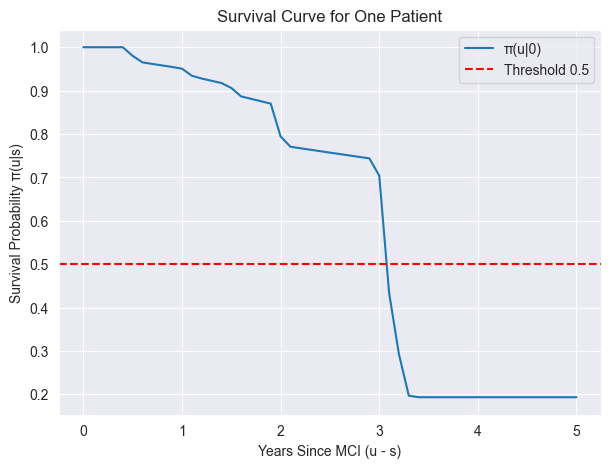

In [30]:
i = 3 # index of the patient
t_pred = predict_time_to_AD(pred[i], H0_func)
t_true = time_np[i]
event = event_np[i]

print(f"📍 Patient {i} | pred Δt: {t_pred} | true Δt: {t_true:.2f} | event: {event}")

plot_survival_curve(pred[i], H0_func)
